We can perform MRZ detection using only basic image processing techniques such as:

- thresholding.
- morphological operations.
- contour properties.


In [1]:
# import the necessary packages
from imutils import paths
import numpy as np
# import argparse
import imutils
import cv2

import matplotlib.pyplot as plt

In [2]:
import pytesseract

from PIL import Image

## I. How to use Tesseract in Python:

In [3]:
imagePath = "/home/system-gru/KerasTest/Attention Demo/example_03.png"
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

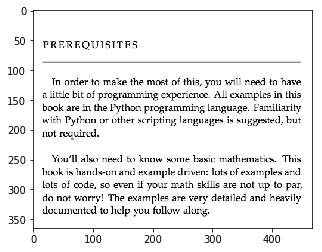

In [4]:
plt.imshow(gray, cmap='gray')

2 dạng bộ lọc xử lý: threshold và blur:

In [5]:
# check to see if we should apply thresholding to preprocess the
# image
# gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# make a check to see if median blurring should be done to remove
# noise
# gray = cv2.medianBlur(gray, 3)

In [6]:
post_processing_img_path = "test.png"
cv2.imwrite(post_processing_img_path, gray)

True

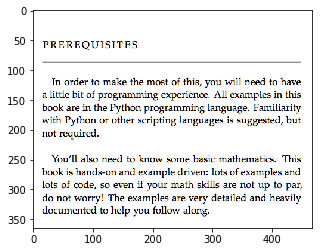

In [7]:
plt.imshow(cv2.imread(imagePath))

In [8]:
text = pytesseract.image_to_string(Image.open(imagePath))

In [9]:
print(text)

PREREQUISITES

In order In make the rnosi of this, you will need (a have
a little bit of pregrarrmung experience. All examples in this
book are in the Python programming language. Familiarity
with Pyihon or other scriphng languages is suggesied, but
mm required.

You'll also need (a know some basic mathematics. This
book is handson and example driven: leis of examples and
lots of code, so even if your math skills are noi up to par.
do noi worry! The examples are very damned and heavily
documented (a help yuu follaw along.



### Important notes:
However, as I’ve mentioned multiple times in these previous posts, Tesseract should not be considered a general, off-the-shelf solution for Optical Character Recognition capable of obtaining high accuracy.

In some cases, it will work great — and in others, it will fail miserably.

## II. How to use Tesseract in Python:


A great example of such a use case is credit card recognition, where given an input image,
we wish to:
- Detect the location of the credit card in the image.
- Localize the four groupings of four digits, pertaining to the sixteen digits on the credit card.
- Apply OCR to recognize the sixteen digits on the credit card.
- Recognize the type of credit card (i.e., Visa, MasterCard, American Express, etc.).

Các loại OCR system:
- OCR-A.
- OCR-B.
- MICR E-13B

For this tutorial, we will make "a template matching system" for the OCR-A font, commonly found on the front of credit/debit cards.

In [10]:
# import the necessary packages
from imutils import contours
import numpy as np
# import argparse
import imutils
import cv2

In [11]:
# define a dictionary that maps the first digit of a credit card
# number to the credit card type
FIRST_NUMBER = {
    "3": "American Express",
    "4": "Visa",
    "5": "MasterCard",
    "6": "Discover Card"
}

In [12]:
reference_path = "/home/system-gru/KerasTest/Attention Demo/template-matching-ocr/ocr_a_reference.png"

In [13]:
# load the reference OCR-A image from disk, convert it to grayscale,
# and threshold it, such that the digits appear as *white* on a
# *black* background
# and invert it, such that the digits appear as *white* on a *black*
ref = cv2.imread(reference_path)
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
ref = cv2.threshold(ref, 10, 255, cv2.THRESH_BINARY_INV)[1]

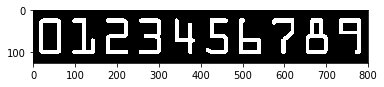

In [14]:
plt.imshow(ref, cmap="gray")

In [15]:
# find contours in the OCR-A image (i.e,. the outlines of the digits)
# sort them from left to right, and initialize a dictionary to map
# digit name to the ROI
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
refCnts = imutils.grab_contours(refCnts)
refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]
digits = {}

In [16]:
# loop over the OCR-A reference contours
for (i, c) in enumerate(refCnts):
    # compute the bounding box for the digit, extract it, and resize
    # it to a fixed size
    (x, y, w, h) = cv2.boundingRect(c)
    roi = ref[y:y + h, x:x + w]
    roi = cv2.resize(roi, (57, 88))
 
    # update the digits dictionary, mapping the digit name to the ROI
    digits[i] = roi

In [17]:
# initialize a rectangular (wider than it is tall) and square
# structuring kernel
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

In [18]:
# load the input image, resize it, and convert it to grayscale
image = cv2.imread("/home/system-gru/KerasTest/Attention Demo/template-matching-ocr/images/credit_card_01.png")
image = imutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

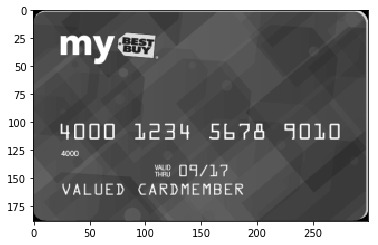

In [19]:
plt.imshow(gray, cmap="gray")

In [20]:
# apply a tophat (whitehat) morphological operator to find light
# regions against a dark background (i.e., the credit card numbers)
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)

In [21]:
# compute the Scharr gradient of the tophat image, then scale
# the rest back into the range [0, 255]
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

In [75]:
# apply a closing operation using the rectangular kernel to help
# cloes gaps in between credit card number digits, then apply
# Otsu's thresholding method to binarize the image
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255,
                       cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] 
# apply a second closing operation to the binary image, again
# to help close gaps between credit card number regions
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)

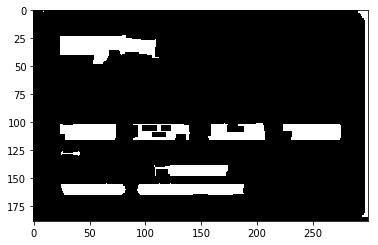

In [76]:
plt.imshow(thresh, cmap="gray")

In [84]:
# find contours in the thresholded image, then initialize the
# list of digit locations
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
locs = []

# loop over the contours
for (i, c) in enumerate(cnts):
	# compute the bounding box of the contour, then use the
	# bounding box coordinates to derive the aspect ratio
	(x, y, w, h) = cv2.boundingRect(c)
	ar = w / float(h)

	# since credit cards used a fixed size fonts with 4 groups
	# of 4 digits, we can prune potential contours based on the
	# aspect ratio
	if ar > 2.5 and ar < 4.0:
		# contours can further be pruned on minimum/maximum width
		# and height
		if (w > 40 and w < 55) and (h > 10 and h < 20):
			# append the bounding box region of the digits group
			# to our locations list
			locs.append((x, y, w, h))

In [85]:
# 	# since credit cards used a fixed size fonts with 4 groups
# 	# of 4 digits, we can prune potential contours based on the
# 	# aspect ratio
# 	if ar > 2.5 and ar < 4.0:
# 		# contours can further be pruned on minimum/maximum width
# 		# and height
# 		if (w > 40 and w < 55) and (h > 10 and h < 20):
# 			# append the bounding box region of the digits group
# 			# to our locations list
# 			locs.append((x, y, w, h))

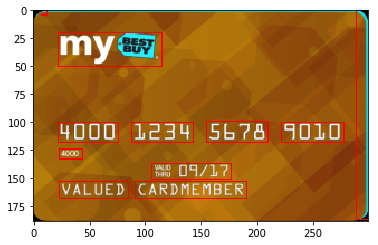

In [79]:
temp = image.copy()
for (i, (gX, gY, gW, gH)) in enumerate(locs):
    cv2.rectangle(temp, (gX - 2, gY - 2), (gX + gW + 2 , gY + gH + 2), (255, 0, 0), 1)
plt.imshow(temp)

In [80]:
# sort the digit locations from left-to-right, then initialize the
# list of classified digits
locs = sorted(locs, key=lambda x:x[0])
output = []

In [86]:
# loop over the 4 groupings of 4 digits
for (i, (gX, gY, gW, gH)) in enumerate(locs):
	# initialize the list of group digits
	groupOutput = []

	# extract the group ROI of 4 digits from the grayscale image,
	# then apply thresholding to segment the digits from the
	# background of the credit card
	group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
	group = cv2.threshold(group, 0, 255,
		cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

	# detect the contours of each individual digit in the group,
	# then sort the digit contours from left to right
	digitCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	digitCnts = imutils.grab_contours(digitCnts)
	digitCnts = contours.sort_contours(digitCnts,
		method="left-to-right")[0]

	# loop over the digit contours
	for c in digitCnts:
		# compute the bounding box of the individual digit, extract
		# the digit, and resize it to have the same fixed size as
		# the reference OCR-A images
		(x, y, w, h) = cv2.boundingRect(c)
		roi = group[y:y + h, x:x + w]
		roi = cv2.resize(roi, (57, 88))

		# initialize a list of template matching scores
		scores = []

		# loop over the reference digit name and digit ROI
		for (digit, digitROI) in digits.items():
			# apply correlation-based template matching, take the
			# score, and update the scores list
			result = cv2.matchTemplate(roi, digitROI,
				cv2.TM_CCOEFF)
			(_, score, _, _) = cv2.minMaxLoc(result)
			scores.append(score)

		# the classification for the digit ROI will be the reference
		# digit name with the *largest* template matching score
		groupOutput.append(str(np.argmax(scores)))

	# draw the digit classifications around the group
	cv2.rectangle(image, (gX - 5, gY - 5),
		(gX + gW + 5, gY + gH + 5), (0, 0, 255), 2)
	cv2.putText(image, "".join(groupOutput), (gX, gY - 15),
		cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)

	# update the output digits list
	output.extend(groupOutput)

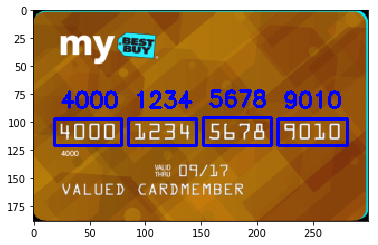

In [87]:
plt.imshow(image)